# <center> Proyecto integrador de la materia Comunicaciones Digitales

In [6]:
#---------------------------------------------------------------------------------
# Project    : Proyecto Integrador
# Authors    : Mugni Juan Mauricio
# Affiliation: UNC
# E-mail     : mauricio.mugni@mi.unc.edu.ar
#---------------------------------------------------------------------------------

## Consigna

Realizar una simulación de la transmisión y recepción con modulación LoRa, en el cual se pueda entender el funcionamiento. 

Luego agregarle ruido y los efectos del canal satelital.

## Resolución

Comenzamos importando las librerías necesarias.

In [12]:
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
from sympy import li
from scipy.fft import fft, fftfreq, fftshift
from IPython.display import Image

### Marco Teórico

#### ¿Qué es LPWAN?

Es una `red` de área amplia e inalámbrica, especializada para dispositivos con baja tasa de datos, centrándose en el alcance y la eficiencia energética.

Su nombre significa _Low Power Wide Area Network_ (LPWAN).

Incluye la comunicación Sigfox, LoRaWAN y el nuevo Radiocrafts Industrial IoT (RIIoT). Están diseñados para conectar sensores que operan a una frecuencia de muestreo baja, y envían ráfagas de datos cortos a larga distancias.
La teoría de la información establece que cuanto mayor sea la SNR, o más estrecho sea el ancho de banda, menor será la tasa de error.

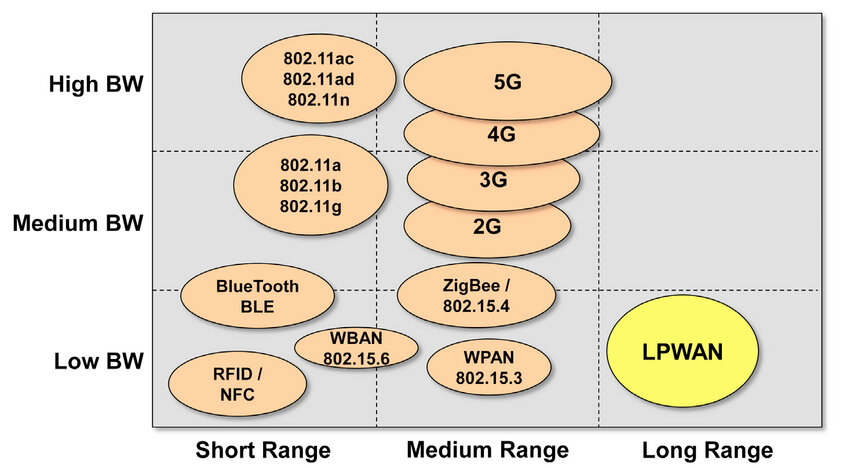

In [15]:
Image(filename='Imagenes/Range-of-different-wireless-technologies.jpg')

Como vemos en la imagen superior el ancho de banda estrecho de las LPWAN les permite operar en rangos más largos a menor potencia.
A frecuencias más bajas, los obstáculos como las paredes y los edificios absorben menos energía de radiofrecuencia, lo que proporciona a estos sistemas una excelente capacidad de penetración en entornos urbanos.

Hay múltiples opciones de `protocolos de comunicación` en las redes LPWAN para elegir, pero para los desarrollos de IoT se utilizan las siguientes:
* LoraWAN
* Sigfox
* RIIoT

#### LoraWAN
> LoRaWAN es uno de los más importantes y amplios protocolos para establecer comunicaciones a largas distancias.
>
> Se basa en estándares abiertos administrados por LoRa Alliance y en tecnología de radio de espectro extendido patentada, de propiedad y con licencia de _Semtech Corp_. La red utiliza una topología de estrella extendida, lo que permite que los nodos individuales se comuniquen con múltiples puertas de enlace, lo que permite el _roaming_ (término que hace referencia a que el dispositivo se conecta a otra red disponible ya que está fuera de alcance de la red principal). Admite comunicaciones bidireccionales entre puertas de enlace y nodos.

#### Sigfox
> Es un protocolo patentado, desarrollado y administrado por Sigfox que otorga licencias de su tecnología a los desarrolladores de chips y brinda a los usuarios acceso a su red a través de estaciones de base de puertas de enlace a todo el mundo.
>
> Los nodos solo pueden enviar 140 mensajes por día, y las puertas de enlace solo pueden enviar mensajes de enlace a los nodos cuatro veces por día, después de recibir un mensaje de los mismos.
> 
> Los nodos pasan muy poco tiempo con sus radios activas, permaneciendo en modo suspensión la mayor parte del tiempo para minimizar su consumo de energía.

#### RIIoT
> El nombre significa Radiocrafts Industrial IoT.
> 
> Es una de las opciones más nuevas. Es desarrollado para aplicaciones de medición inteligente y control de procesos. Agrega funciones de RF y control de acceso a medios para admitir bajo consumo de energía, largo alcance y seguridad avanzada.
>
> La comunicación es bidireccional a través de una red en estrella.
> 
> Cada nodo puede tener una clave de seguridad única, lo que permite que el sistema mantenga el mensaje cifrado desde el nodo hasta el programa de aplicación basado en la nube que interactúa con él. Las puertas de enlace simplemente pueden pasar el mensaje cifrado; no necesitan acceder a los contenidos.

Con las siguiente imagen podemos comparar el poder de penetración de cada modulación.

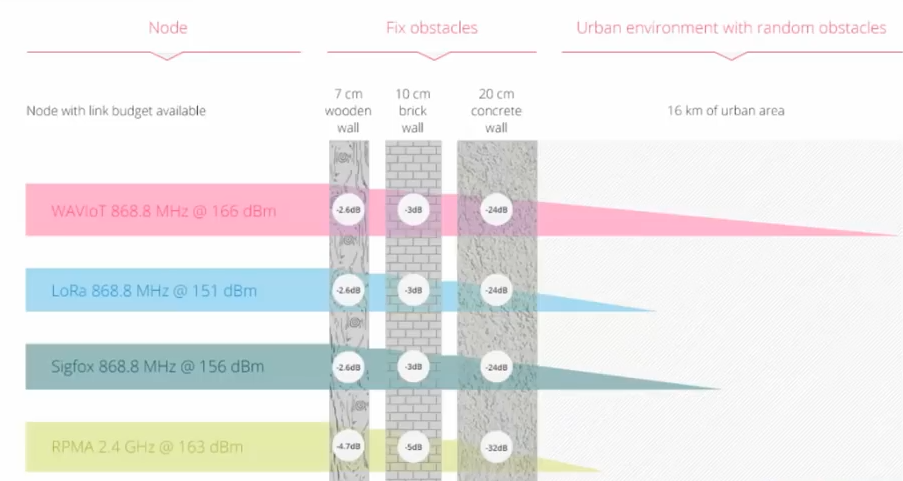

In [17]:
Image(filename='Imagenes/Penetracion-Alcance.png')

#### ¿Qué es LoRa?
LoRa es la `capa física` de acceso a la red LoRaWAN, y define el protocolo de acceso a la red y la arquitectura del sistema. Es la abreviatura de _Long Range_ (largo alcance), y permite:
* Conectividad a larga distancia
* Conexión segura mediante encriptación.
* Envío bidireccional de paquetes de datos.
* Consumo eléctrico mínimo.
* Opera en la banda ISM (_Industrial, Scientific and Medical_) de radio que está habilitada en todo el mundo para uso no comercial y no necesita licencia.
* Las frecuencias utilizadas varían según el país o region.

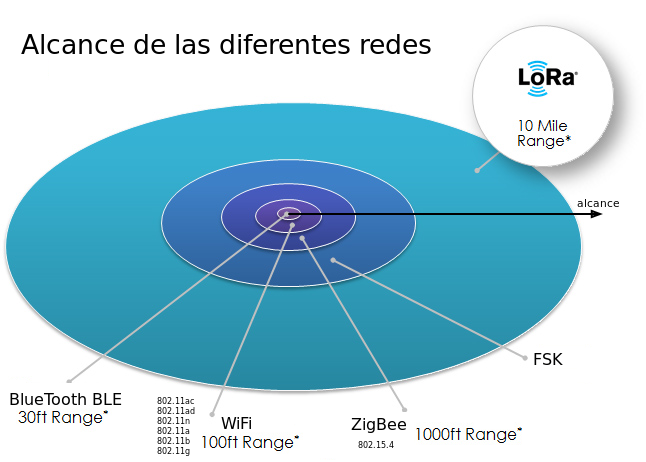

In [19]:
Image(filename='Imagenes/AlcanceLoRaModificado1.png')

Si ahora lo comparamos con otras modulaciones teniendo en cuenta el _ancho de banda_ y _alcance_, vemos que su ancho de banda es reducido comparado al resto. Por lo que no es utilizado para enviar vídeos o imagenes. Su uso es de envío de telemetría, es decir, datos de sensores como temperatura, presión, humedad, estado lógico, etc.

Pero se destaca por la distancia a la que puede llegar.

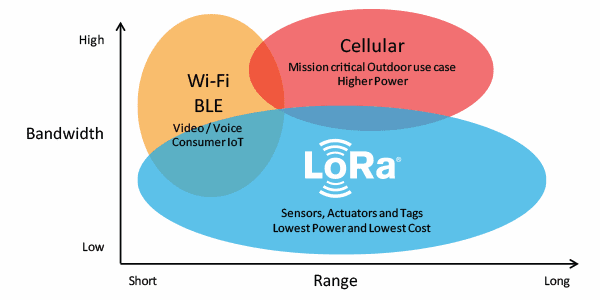

In [21]:
Image(filename='Imagenes/BW&Distancia.png')

No solo puede llegar lejos, además presenta un consumo muy reducido lo que lo convierte ideal para aplicaciones IoT (_Internet of Things_).  

Para alcanzar ese rango LoRa adopta la modulación *Chirp Spread Spectrum* (CSS) que se utiliza en aplicaciones espaciales y militares. Además utiliza la codificación de errores directa.

_Chirp Spread Spectrum_ (CSS) es una técnica de modulación que utiliza _chirps_ (señales cuya frecuencia aumenta o disminuye con el tiempo) para codificar información. Esta técnica es particularmente útil en entornos de comunicaciones inalámbricas debido a su resistencia al ruido, interferencias y su capacidad para penetrar obstáculos.

Un _chirp_ es una señal cuya frecuencia cambia linealmente con el tiempo. Existen dos tipos básicos de chirps: 
* chirps ascendentes (_up-chirps_), matemáticamente se puede escribir como:
    $$f(t)=f_0 + kt$$
* chirps descendentes (_down-chirps_):
    $$f(t)=f_0 - kt$$
  
donde $f_0$ es la frecuencia inicial y $k$ es la tasa de cambio de frecuencia.

La señal recibida realiza un barrido en frecuencia, desde una frecuencia incial a una límite. Es decir, cuando se alcanza la frecuencia máxima (mínima para el _down chirp_) se vuelve a la frecuencia mínima (máxima para el _down chirp_) y el proceso comienza nuevamente. 

En la imagen siguiente podemos ver como varía la frecuencia de la señal que se recibe. Puede ser ascendente (se mueve de izquierda a derecha la señal `verde` ) o descendente ( se mueve de derecha a izquierda la señal `verde`). Y lo que se visualiza en `azúl` es como la frecuencia se incrementa hasta llegar al valor máximo o al valor mínimo si disminuye la frecuencia, para los distintos bits a transmitir.

En verde vemos un mayor ancho de banda ya que es donde estamos buscando la señal con modulación LoRa.

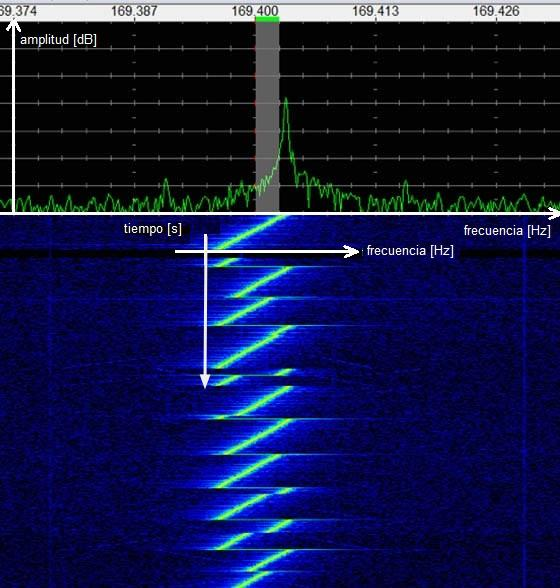

In [27]:
Image(filename='Imagenes/LoRa-Modulation.jpeg')

En la imagen anterior no solo estamos viendo como cambia la frecuencia con el tiempo, también su intensidad. El color celeste nos indica cuales son las frecuencias que están por encima del nivel de ruido, y en azúl oscuro donde no se ha detectado esa frecuencia.

En en el siguiente [vídeo](https://www.youtube.com/watch?v=MhUbP64o4fg&t=26s) podemos ver una animación para mayor aclaración.

Podemos visualizar también el _chirp_ en el tiempo, para los dos casos mencionados.

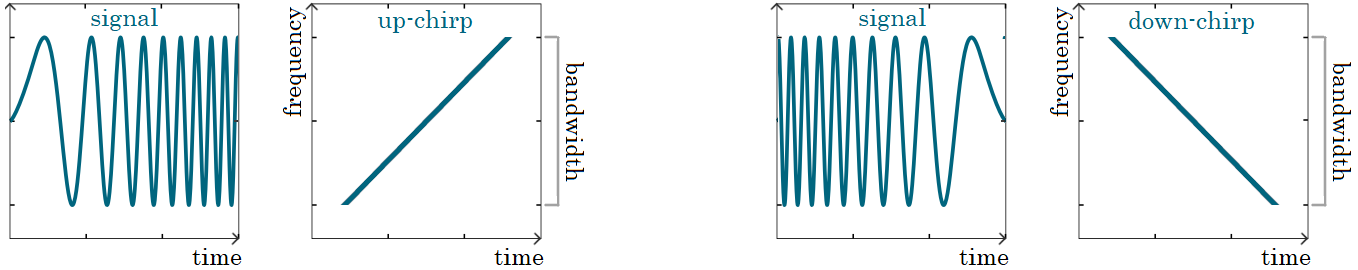

In [30]:
Image(filename='Imagenes/lora-chirps.png')

En la imagen de arriba podemos ver como varía la señal en el tiempo y en la frecuencia para los casos mencionados. Se aclara que el ancho de banda no tiene nada que ver con la amplitud de la señal en el tiempo, el ancho de banda esta definido por la frecuencia mínima y máxima de la señal, la amplitud por la potencia de la misma.

A esta señal de barrido también se la conoce como "chirrido", y puede cambiar su frecuencia a una velocidad constante (como se muestra anteriormente) o exponencial.

Los llamados pulsos de "chirrido" se envían como símbolos, que aumentan o disminuyen la frecuencia a lo largo del tiempo.

La transmisión de datos se realiza mediante la secuencia de estos pulsos de "chirrido".

En la siguiente imagen podemos ver como es la secuencia de "chirridos" enviados:

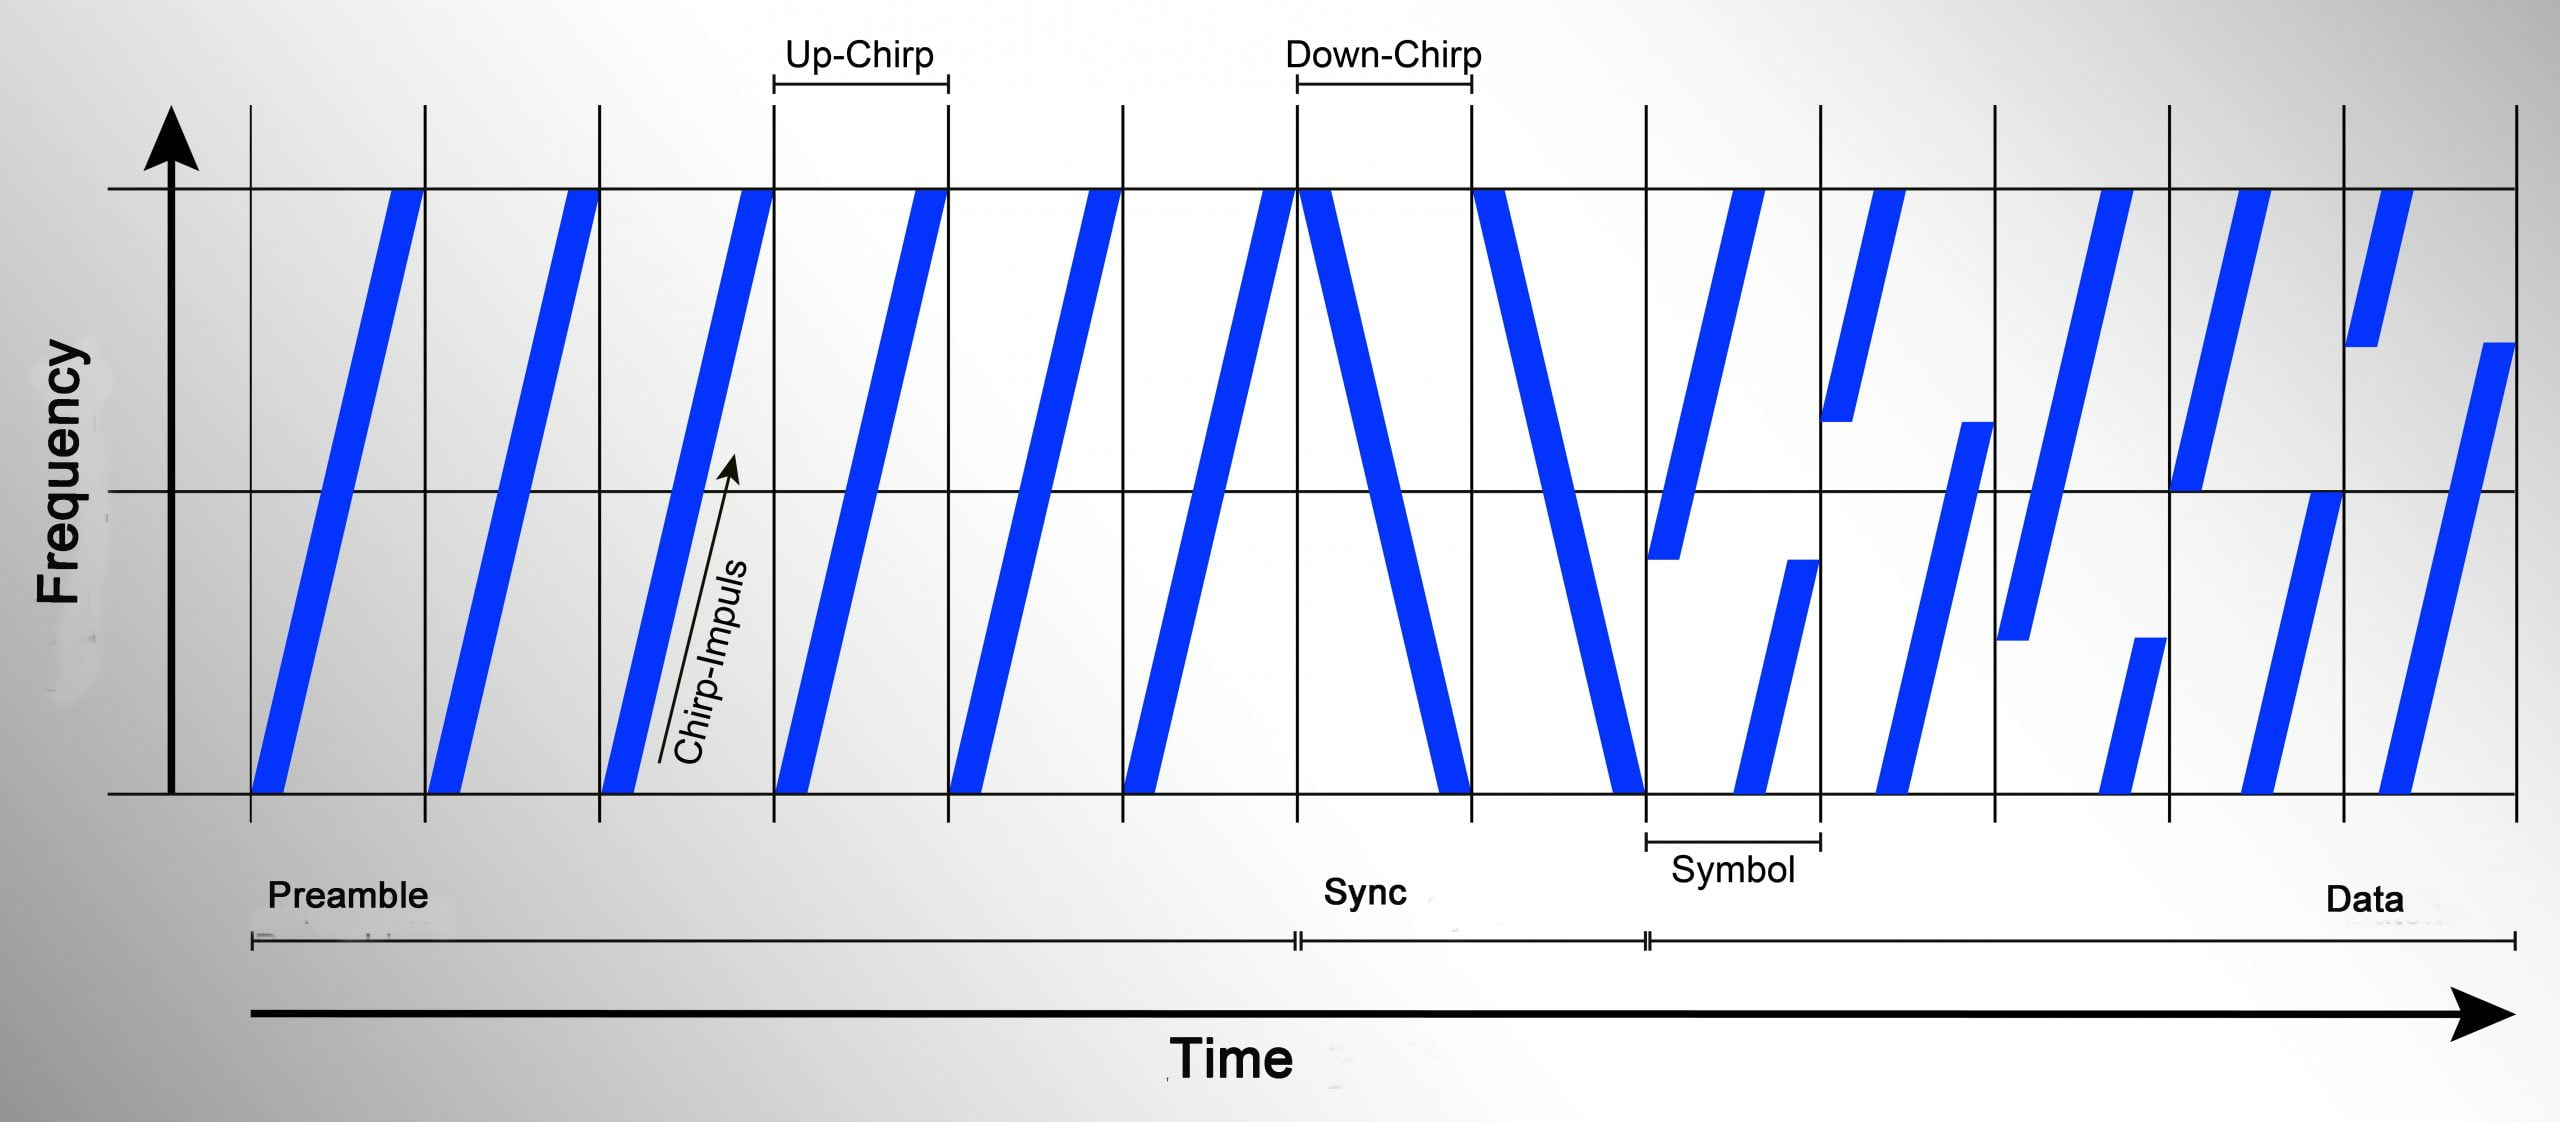

In [33]:
Image(filename='Imagenes/lora-Frequency-scaled.jpg')

Cuando se procesa un mensaje LoRa se transmite primero el `preámbulo`, que son varios "chirridos" constante para lograr la detección de la señal LoRa. Hay que tener en cuenta que el receptor puede estar desalineado por esta razón se envían varias veces el cero para poder calibrar al receptor. El preámbulo se compone de dos a diez _up-chirp_, es el símbolo cero repetido algunas veces. 

Los dos _down-chirp_ siguientes (dos chirridos descendentes) son para la `sincronización` de tiempo. Luego, se comienza con la transmisión de datos, en primer lugar el `símbolo`y luego los `datos`.

Para la demodulación, ocurre lo contrario. Primero se elimina el `preámbulo` y luego se averigua que símbolo se transmitió.

La idea de la decodificación LoRa es la siguiente: 

'Mientras codificamos LoRa, cambiamos cíclicamente la frecuencia de la señal LoRa. Entonces, si multiplicamos el "chirrido" detectado por el "chirrido" inverso obtendremos la señal con una frecuencia específica constante. Si tomamos la Transformada Rápida de Fourier (FFT - _Fast Fourier Transform_) sobre el símbolo, la parte de mayor energía representará el símbolo transmitido.'

A continuación se brinda un ejemplo para mayor aclaración:

> Supongamos que estamos transmitiendo un mensaje LoRa que tiene cuatro símbolos de preámbulo, dos símbolos de sincronización ($32$ , $32$) y cuatro símbolos de mensaje ($10$, $80$, $185$, $55$). Tomando un factor de dispersión de $8$. El mensaje se vería así:


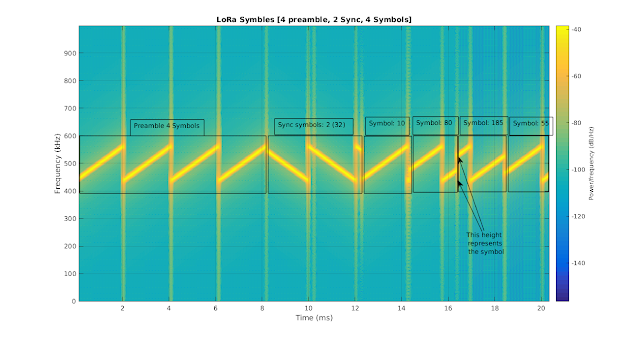

In [36]:
Image(filename='Imagenes/LoRa_Sym_generated.png')

> Como el _Spreading Factor_ es $8$, podemos transmitir $8$ bits por símbolo. Donde los símbolos van de $0$ a $255$.
> 
> Entonces el chirrido completo se divide por $256$, esto por que estamos usando $SF = 8$.
>
> En el lado del receptor, este mensaje se multiplica por un chirrido inverso (_down-chirps_). Y en el espectrograma se ve de la siguiente manera:

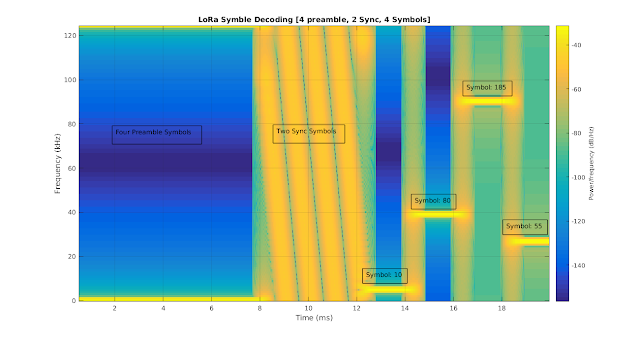

In [39]:
Image(filename='Imagenes/LoRa_Sym_decoding.png')

> Después de multiplicar por el _chirp_ inverso se observa el preámbulo, los símbolos de sincronización y los símbolos del mensaje.
> 
> Los símbolos del mensaje recibido tienen frecuencias constantes. En el eje $y$ se representa el símbolo y en el eje $x$ se representa el tiempo en el aire.
>
> Ahora se realiza la Transformada Rápida de Fourier para chequear cuales frecuencias tienen mayores energía.
>
> Y se obtiene lo siguiente:

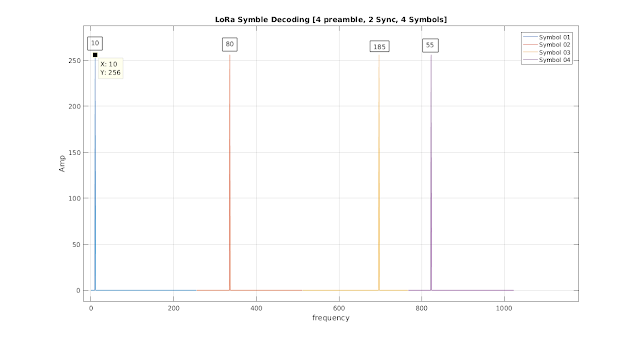

In [42]:
Image(filename='Imagenes/LoRa_Sym_FFT.png')

> Y estos son los símbolos obtenidos, las frecuencias que tienen más energía son un símbolo, y de esta manera se pueden extraer los datos.

La modulación LoRa es definida por los siguientes parametros:
* Ancho de banda (BW - _Bandwith_), es la diferencia entre la frecuencia mínima y máxima.
* Factor de dispersión (SF - _Spreading Factor_), es la cantidad de bits codificados por símbolo.
* (CR - _Coding Rate_), es una medidad de la cantidad de corrección de errores.

Un mayor _Spreading Factor_ me permite mayor alcance a coste de menor ancho de banda, es decir, menor transmisión de bits. Este valor me determina la cantidad de datos redundantes que se envían en la transmisión, un valor alto significa muchos datos redundantes y se logra un mayor alcance con baja velocidad.

En la siguiente imagen se muestra como aumenta el tiempo de transmisión al aumentar el factor de dispersión.

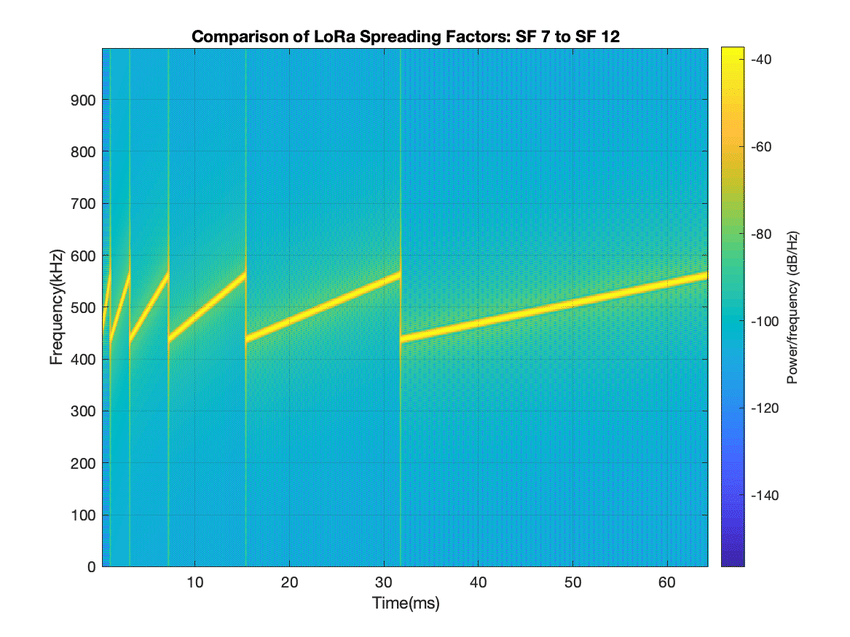

In [46]:
Image(filename='Imagenes/LoRa-uses-a-chirp-spread-spectrum-modulation-technique.png')

La duración de un símbolo, duración del _chirp_, se calcula como:
$$ T_S = \frac{2^{SF}}{BW}$$

El numerador se conoce como $M = 2^{SF}$ la cardinalidad del alfabeto de modulación.

Se observa que para un SF dado, la transmisión LoRa tiene un conjunto de $M = 2^{SF}$ _chirps_ diferentes, cada uno de los cuales corresponden con uno de los símbolos de la modulación del alfabeto: $S={0,1,2,...M-1}$. Para cada secuencia de bits transmitidos, el modulador selecciona la correspondiente modulación del símbolo y transmite el _chirp_ el cual tiene un único símbolo asociado.

Para elegir cierto _Spreading Factor_ se debe tenerse en cuenta no solo el alcance y la cantidad de datos a transmitir, también el oscilador del microcontrolador a utilizar. Para poder lograr el factor de disperción deseado, el ciclo de trabajo del microcontrolador debe tener una precisión del $1$ al $10$ por ciento.

A continuación se explicará la modulación y demodulación de LoRa, para ello se utilizó el siguiente paper: [Frequency Shift Chirp Modulation: the $LoRa^{TM}$ Modulation](https://ieeexplore.ieee.org/document/8067462)

#### Modulación

Se envía un símbolo $s$ cada $T_S$. El símbolo es un número real formado por un vector $w(nT_S)$ con $SF$ digitos binarios.

$$ s(nT_S) = \sum_{h=0}^{SF-1} w(nT_S)_h \space 2^h $$

Los símbolos toman los siguientes valores: ${0, 1, 2, ..., 2^{SF}-1}$

La forma de onda (_waveform_) de duración $T_S$ para un cierto símbolo $s(nT_S)$ es:

$$
\begin{aligned}
\huge c(nT_S + kT) &= \huge \frac{1}{\sqrt{s^{SF}}}e^{j2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]kT\frac{BW}{2^{SF}}} \\
&= \huge \frac{1}{\sqrt{s^{SF}}}e^{j2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]\frac{k}{2^{SF}}}
\end{aligned}
$$

donde $k=0, 1, 2, ..., 2^{SF}-1$

Nosotros podemos ver que la modulación de la señal es una forma de onda conocida como _chirp_ (ya anteriormente gráficada) que incrementa linealmente con $k$ en el tiempo. Cada _waveform_ tiene una frecuencia inicial diferente dada por el símbolo que representa.

Esto es conocido como Modulación de Chirrido por Desplazamiento en Frecuencia (_Frequency Shift Chirp Modulation_ - FSCM).

#### Ortogonalidad de las _waveforms_ FSCM

Teniendo ya establecido las _waveforms_ de la FSCM, se investiga su ortogonalidad.

La ortogonalidad implica la transmisión eficiente y confiable de múltiples señales a través del mismo medio, mejorando la capacidad del canal y reduciendo la interferencia.

Para este fin se realiza el producto punto o producto interno de dos _waveform_ de distintos símbolos asociado:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = 0 \quad \text{para} \quad i \neq q, \quad i, q \in \{0, \ldots, 2^{SF}-1\}
$$

Por definición del producto interno discreto de dos señales discretas nos queda:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \sum_{k=0}^{2^{SF}-1} c(nT_S + kT)\big|_{s(nT_S)=i} \space c^*(nT_S + kT)\big|_{s(nT_S)=q}
$$

Donde $2^{SF}-1$ es la longitud de la señal, y se esta multiplicando la señal por su complejo conjugado.

Reemplazando cada forma de onda por su valor correspondiente, nos queda:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{2^{SF}}\sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[(i+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}} \cdot e^{-j2\pi\left[(q+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}}
$$

Sacando factor común en el exponente ($j2\pi$ y $\frac{k}{2^{SF}}$) y agrupando:

$$
\large \left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[(i+k) \bmod\ 2^{SF} - (q+k) \bmod\ 2^{SF}\right]\frac{k}{2^{SF}}}
$$

Se puede dividir en tres partes, eliminando el operador modulo:

$$
= \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[(i+k)-(q+k)\right]\frac{k}{2^{SF}}} + \frac{1}{2^{SF}} \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[(i+k-2^{SF})-(q+k)\right]\frac{k}{2^{SF}}} + \frac{1}{2^{SF}} \sum_{k=2^{SF}-q}^{2^{SF}-1} e^{j2\pi\left[(i+k-2^{SF})-(q+k-2^{SF})\right]\frac{k}{2^{SF}}}
$$

Operando en cada exponente de los términos nos queda:

$$
\large = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} + \frac{1}{2^{SF}} \sum_{k=2^{SF}-1-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}\space e^{-j2\pi\left[2^{SF}\right]\frac{k}{2^{SF}}} + \frac{1}{2^{SF}} \sum_{k=2^{SF}-1-q}^{2^{SF}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$

* Analizamos el primer término:

$$
\large \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF-1}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} + e^{j2\pi\left[i-q\right]\frac{k+2^{SF-1}}{2^{SF}}}
$$
$$
\large = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF-1}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} + e^{j2\pi\left[i-q\right]\left(\frac{k}{2^{SF}}+\frac{1}{2}\right)}
$$
$$
\large = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF-1}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} + e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$
$$\large = 0$$
* Analizamos el segundo término:


* Analizamos el tercer término:


Entonces se puede concluir que $c(nT_S + kT)\big|_{s(nT_S)=i}$ es una base ortogonal, ya que se cumple:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = 0 \quad \text{para} \quad i \neq q, \quad i, q \in \{0, \ldots, 2^{SF}-1\}
$$


#### Características de LoRa
Las características claves de la tecnología LoRa son:
- Gran alcance: permite conectar más de 30 mil aparatos en areas rurales y penetrar densos espacios urbanos.
- Bajo consumo: requiere mínima energía, prolongando la vida útil de las baterías hasta 10 años. Esto se debe en parte, a que los dispositivos se comunican solo cuando tienen datos listos para ser enviados. No se necesita la sincronización. Cuando un dispositivo transmite, simplemente se despierta, envía un mensaje y se vuelve a dormir.
- Bajo costo: debido a que usa las bandas de frecuencia ISM, se puede operar sin tener que pagar por el espacio aéreo.
- Seguridad: se caracteriza por la encriptación _end-to-end_ AES128, autenticación mutua y protección integrada.
- Estandarización: disponibilidad global en cualquier parte del mundo.
- Geolocalización: permite el desarrollo de aplicaciones de rastreo GPS.
- Portatil: mantiene comunicaciones con dispositivos en movimiento sin sobrecargar el consumo.
- Baja tasa de datos: este protocolo está diseñado para pequeñas cantidades de datos de dispositivos simples como sensores.

#### Aplicaciones de LoRa
Actualmente tiene aplicaciones en:
1. En la agricultura para el monitoreo del ganado. Se registran variables como la temperatura, su ubicación, y productividad del msimo.
2. En los edificios para predecir fallas, registrar variables como movimiento y temperatura; y el control de motores, luces, y otros dispositivos.
3. En las ciudades para hacer más eficiente el uso de la electricidad controlando la iluminación. Se ilumina de manera inteligente ciertas áreas.
4. En la idustria para monitorear recursos como gas, agua, tensión electrica, etc. Y poder controlar diversos procesos.
5. En el monitoreo satélital como se desarrolla en el próximo apartado. 

#### Comunicación con satélites

Esta modulación es un opción potencial para proveer conexión directa a satélites (_direct to satellite_ DtS) apoyando las aplicaciones IoT (_Internet of Things_) y complementando las redes terrestres existentes.

El efecto Doppler es el principal desafío en las comunicaciones LoRa DtS.

Recientes estudios confirman la factibilidad de integrar LoRa con satélites LEO (_Low Earth Orbit_). Sin embargo, solo algunos estudios examinan la influencia del efecto Doppler en el rendimiento de la comunicación LoRa DtS.

Para evitar caer de nuevo a la Tierra debido a la atracción de la gravedad, los satélites LEO orbitan a una velocidad mucho más rápida que la velocidad de rotación de la Tierra. Como  consecuencia del movimiento relativo del satélite y el dispositivo terrestre de recepción, la frecuencia de la portadora de la señal transmitida sufre un cambio significante conocido como `Efecto Doppler`, cuya magnitud varía durante el intervalo de visibilidad del satélite.

Según el _paper_ [_Understanding the Limits of Lora Direct-to-Satellite: The Doppler Perspectives_](https://ieeexplore.ieee.org/document/10335927/references#references), utilizando un _Spreading Factor_ de 12 la conexión DtS es más vulnerable al fenómeno _Doppler Shift_ que para valores bajos de SF.

Las pruebas experimentales confirman que LoRa es más inmune al efecto Doppler cuando se utiliza $7<SF<11$ y un acho de banda mayor a $31.25 kHz$. 

Se analizan dos efectos Doppler:
* Doppler Shift, también llamado Doppler estático.
> Esté degrada el rendimiento de la comunicación para bajos ángulos de elevación, es decir, para la máxima distancia entre el dispositivo receptor y el satélite.
>
> La frecuencia de la portadora se la señal recibida se devía significativamente de la frecuencia de la portadora de la señal transmitida. Esta discrepancia puede producir fallas en la _Phase Locked Loop_ (PLL) de manera tal que no se puede rastrear la señal de entrada y se producen pérdidas de paquetes.
   
* Doppler Rate, conocido como Doppler dinámico.
> En cambio, esté presenta perdidas de paquetes para altos ángulos de elevación. Es decir, para cuando se posiciona justo debajo del dispositivo de recepción terrestre; resulta ser la mínima distancia entre ambos.
>
> Este suceso afecta la capacidad del receptor a permanecer vínculado a la portadora recibida.

La siguiente imagen muestra las regiones afectadas de la comunicación debido al efecto Doppler Shift (marcadas en gris) y por Doppler Rate (marcadas en rojo).




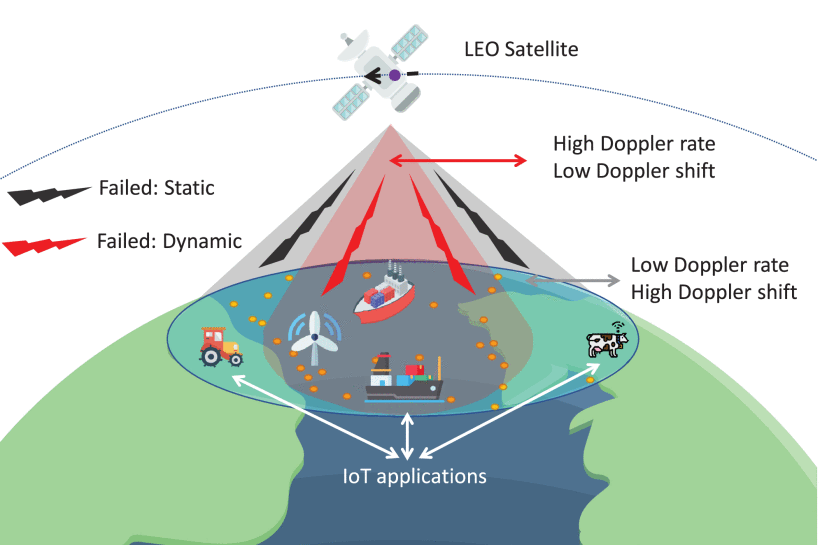

In [51]:
Image(filename='Imagenes/SatelliteDoppler.png')

Recordando que en la cardinalidad del alfabeto de modulación hay M _chirps_, los cuales comienzan con diferentes frecuencias. Estas hacen un barrido según el ancho de banda, desde la inicial hasta la final.

Esto significa que para valores grandes de SF, corresponde a bajos valores de BW, siendo más sensibles al efecto Doppler porque es menor la separación entre las frecuencias de los _chirps_.

Para incrementar la robustez del efecto Doppler dinámico se reduce por dos el número de bits portados por cada símbolo. Para un SF dado, la cardinalidad del alfabeto de modulación se reduce a:
$$M= 2^{SF-2}$$
se incrementa de esta manera la separación de frecuencia entre los chirps por cuatro veces, y por lo tanto, se reduce el efecto del Doppler Rate. Este resultado positivo es a costa de reducir la velocidad de datos.

Para investigar la comunicación LoRa DtS, se comienza explicando la geometría entre el satélite y el dispositivo terrestre.

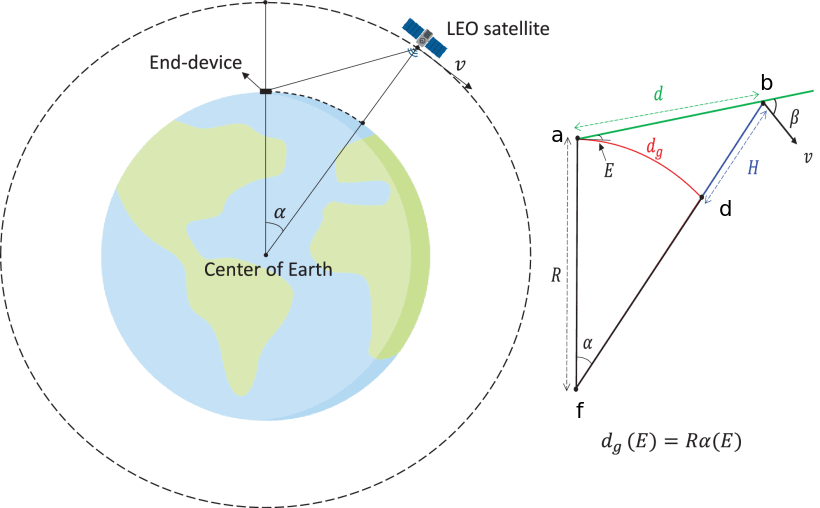

In [73]:
Image(filename='Imagenes/EarthAndSatellite.png')

donde: 

$R = 6371 [km]$ es el radio de la tierra.

$g = 9.81 [\frac{m}{s^2}]$ es la aceleración de la gravedad terrestre.

$c = 299.792.458 [\frac{m}{s}]$ es la velocidad de la luz en el vacío.

$H [km]$ es la altura de la órbita del satélite, distancia del mismo con respecto al suelo.

$d [km]$ es la distancia entre el satélite y el punto de recepción-transmisión.

$v [\frac{km}{h}]$ es la velocidad del satélite en la órbita circular.

$E [°]$ es el ángulo de elevación, está formado por el satélite y el punto terrestre.

$\alpha [rad]$ es el ángulo entre el satélite y el punto _end-device_ teniendo en cuenta el centro de la tierra.

$\beta [°]$ es el ángulo entre la velocidad del satélite y la dirección del punto de operación terrestre.

$\tau $ es el tiempo de visibilidad.

Basandonos en la imagen anterior, uno puede encontrar $d$ para un $E$ dado, y viceversa.

$$ d(E) = R \left[ \sqrt{\left(\frac{H+R}{R}\right)^2 - \cos^2(E) - \sin^2(E)} \right] $$
$$ E(d) = \sin^{-1}\left(\frac{H^2 + 2HR - d^2}{2dR}\right)$$

La proyección del segmento $\overline{ab}$ sobre la superficie terrestre crea un arco definido por el suelo, $d_g(E)$. El largo de este arco es equivalente al producto del radio de la tierra por el ángulo $\alpha$. 

$$d_g(E) = R\alpha(E) = Rsin^{-1}\left(\frac{d(E)cos(E)}{R+H}\right)$$

El tiempo de visibilidad total es definido por:

$$ \tau = 2\frac{d_g(E{min})}{v}$$

Para mantener una orbita circular los satélites LEO giran alrededor de la Tierra a una velocidad muy alta, la cual resulta en un movimiento relativo del satélite respecto a un observador en la superficie terrestre. Este fenómeno introduce un importante cambio de frecuencia en la portadora de la señal recibida, estorbando la demodulación.

La diferencia entre la frecuencia de la portadora de la señal transmitida $F_C$ y la recibida $F_R(t)$, esta última variando en el tiempo debido al movimiento del satélite, se conoce como `Doppler Shift`, y está dado por:

$$F_D(t) = F_R(t) - F_C$$

mientras que su derivada:

$$\Delta F_D(t) = \frac{dF_D(t)}{dt}$$

se conoce como `Doppler Rate`.

Podemos escribir la frecuencia recibida $F_R(t)$ en función de la transmitida $F_C$.

$$F_R(t) = \frac{F_C}{1+\frac{v}{c}cos(\beta(t))}$$

siendo:

$$cos(\beta(t)) = \frac{sin(\varphi(t))}{\sqrt{\left(1+\frac{H}{R}\right)^2 - 2 \left(1 + \frac{H}{R}\right) cos(\varphi(t)) + 1}}$$

en donde:

$$
\large \varphi(t) = t \sqrt{\frac{g}{R}} \left( 1 + \frac{H}{R}\right)^{-\frac{3}{2}}
$$

se debe tener en cuenta que $-\frac{\tau}{2}<t<\frac{\tau}{2}$, y al valer cero el satélite tiene un ángulo de elevación de $E = 90[°]$

Según los experimentos y los documentos de _Semtech Corp_ la modulación LoRa tiene una tolerancia de $\pm25\%$ del ancho de banda al desplazamiento en frecuencia. Por lo tanto, este límite de inmunidad para el Doppler estático es:

$$F_{static} = \pm 0.25 \space BW$$

y la variación de la frecuencia de la portadora sobre el tiempo de la recepción de paquetes debería estar por debajo de:

$$F_{dynamic} = \frac{L \space BW}{3 \space 2^{SF}}$$

donde $L$ vale $16$ cuando el LDRO (_Low Data Rate Optimization_) esta habilitado, y $1$ en caso contrario. Para LoRaWAN, el LDRO es recomendable cuando el símbolo LoRa excede $16.38 [mS]$.

Para modelar el efecto Doppler en el rendimiento de la comunicación LoRa se seguirá el siguiente modelo:

$$
L_{static}(t) =
\begin{cases} 
    1 & \text{if } |F_D(t)|>=|F_{static}| \\
    0 & \text{otherwise } 
\end{cases}
$$
> Refleja las pérdidas de paquetes debido al Doppler estático

$$
L_{dynamic}(t) =
\begin{cases} 
    1 & \text{if } |\Delta F_E(t)|>=F_{dynamic} \\
    0 & \text{otherwise } 
\end{cases}
$$

> Refleja las pérdidas de paquetes debido Doppler dinámico

Donde $\Delta F_E(t)$ representa el cambio en la frecuencia de la portadora desde el comienzo hasta el final de un paquete, definido por:

$$\Delta F_E = F_D[t_{start}] - F_D[t_{end}]$$

$t_{start}$ es el instante en que se comienza con la recepción del paquete, y $t_{end} = t_{start} + ToA$ representa el instante final de la recepción del paquete.

Teniendo en cuenta que ToA (_Time on Air_ - Tiempo en el aire) está dado por  $ToA = T_S \space N_S$, donde $T_S$ como antes vimos es la duración del símbolo y $N_S$ es la cantidad de símbolos en un paquete. 


### Simulación de una transmisión y recepción con modulación LoRa de un solo símbolo

Se comienza simulando el caso para un solo símbolo modulado mediante LoRa.

In [295]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
s   = 17                 # Símbolo a representar
SNR = -5                 # Signal Noise Radio
Fs  = 1000               # Frecuencia de muestreo 
ruido = 2                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital
veces = 1000             # cantidad de veces que se modula y demodula para calcular el error

#-----------Efectos del canal satelital------------#
K = 10                   # Factor K para el desvanecimiento de Rician
doppler_freq = 1         # Frecuencia Doppler
#delay_samples = 100      # Retardo en muestras  
atenuacion_factor = 0.5  # Factor de atenuación

#### Transmisor

##### Modulación

A continuación se define la función para modular una onda para cada símbolo *s* dado, que más adelante se usara.

Los parámetros de entrada serán: 

* $T_s = \frac{2^{SF}}{BW}$ y esto me indica la duración de cada símbolo, su periodo.

* $num samples = T_s F_s$ es el número de muestras en un periodo. 

* $s$ es el símbolo que se quiere representar.

* $SF$ es el _Spreading Factor_ ya definido al comienzo.

Y esta función me retorna la modulación en frecuencia y en el tiempo de cada símbolo.

In [300]:
def generar_symb(Ts, num_samples, s, SF):
    
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        
        if k >= 2**SF:
            k = k - 2**SF
        
        k = k + 1 
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))  # Chirps ascendentes

    return symb_t, symb_f

Se procede a definir el periodo de cada símbolo y su tasa de muestreo, para hacer uso de la función anterior.

In [303]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Duración de casa símbolo:  0.128  [S]


Se modula una onda para el símbolo dado.

In [306]:
[symb_t, symb_f] = generar_symb(Ts, num_samples, s, SF)

Se define el vector tiempo del símbolo, y la cantidad de puntos que este tiene.

In [309]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en las imagenes siguiente
message_part = 2**SF                               # Cantidad de puntos de cada símbolo

Procedemos a gráficar como se vería las variaciones de frecuencia y tiempo por símbolo en el eje real.

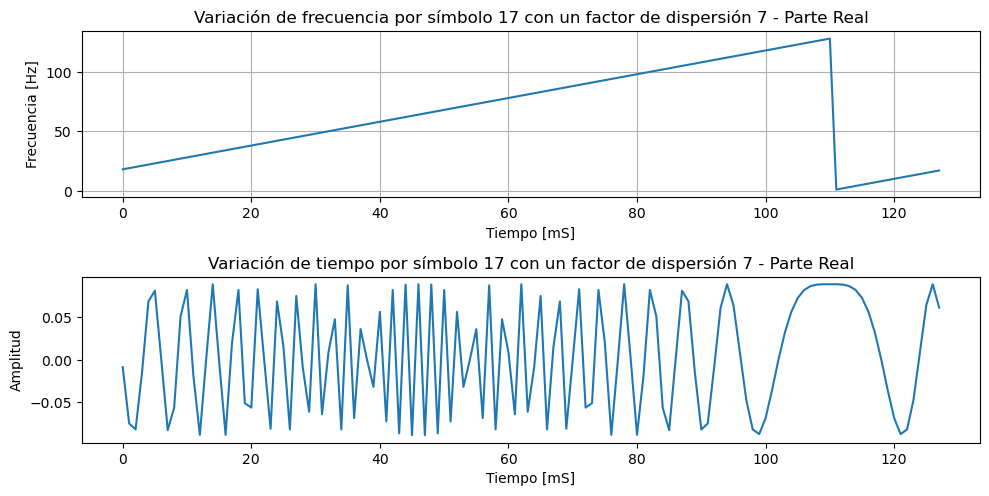

In [312]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación de frecuencia por símbolo
plt.subplot(5, 1, 1)
plt.plot( time_axis, symb_f.real)

title_Text1 = f"Variación de frecuencia por símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Frecuencia [Hz]")
plt.grid()

# Subplot 2: Variación de tiempo por símbolo
plt.subplot(5, 1, 2)
plt.plot( time_axis, symb_t.real)

title_Text1 = f"Variación de tiempo por símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Como estamos simulando un caso _up-chirp_, podemos ver que se inicia en la frecuencia del símbolo a transmitir y asciende hasta su máximo $2^{SF}$ provocando una discontinuidad, y vuelve a empezar.

En segunda gráfica notamos como cambia la frecuencia de la onda con la modulación. Se puede ver que en la discontinuidad (comienzo de la menor frecuencia y fin de la más alta) es donde la señal tiene menor frecuencia. 

#### Ruido

En este paso se le agrega ruido a la señal. Para ello se crea la siguiente función, donde los parámetros para pasarle son:
* `simbolo_lora` que representa el símbolo al cual hay que agregarle ruido.
* `SNR` como se explico antes se utiliza para comparar el nivel de ruido con respecto a la señal.
* `modo` que se utiliza para indicar el tipo de ruido que se vaya a agregar. 

In [317]:
def agregar_ruido(simbolo_lora, SNR, modo):

    if modo == 0: # Sin ruido - canal ideal
        
        return simbolo_lora
    
    else: # Ruido AWGN   
        # Cálculo de potencia de señal y conversión a decibelios
        prom_watts = np.mean(np.abs(simbolo_lora)**2)
        prom_db = 10 * np.log10(prom_watts)

        # Cálculo de ruido en watts
        prom_ruido_db = prom_db - SNR
        noise_avg_watts = 10 ** (prom_ruido_db / 10)

        # Generar ruido blanco complejo
        noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(simbolo_lora)) + 1j * np.random.normal(0, 1, len(simbolo_lora)))

        # Añadir ruido a la señal original
        simb_ruidoso = simbolo_lora + noise

        if modo == 1: # Ruido AWGN 
            
            return simb_ruidoso     
        
        else:         # Efectos canal satélital: AWGN + desvanecimiento Rician + retardo + atenuación  --> sin retardo por el momento

            num_samples = len(simb_ruidoso)
            t = np.arange(num_samples) / Fs

            # Componente LOS
            los_component = np.sqrt(K / (K + 1)) * simb_ruidoso           

            # Componente multipath
            multipath_component = np.zeros_like(simb_ruidoso, dtype=np.complex128)
            num_paths = 10  # Número de caminos en el modelo de desvanecimiento Rician
            
            for i in range(num_paths):
                phase_shift = 2 * np.pi * np.random.rand()
                doppler_shift = doppler_freq * np.cos(2 * np.pi * np.random.rand()) * t
                multipath_component += (1 / np.sqrt(num_paths)) * np.exp(1j * (2 * np.pi * doppler_shift + phase_shift))

            multipath_component = np.sqrt(1 / (K + 1)) * simb_ruidoso * multipath_component
            rician_signal = los_component + multipath_component

            # Aplicar retardo
            #delayed_signal = np.zeros_like(rician_signal, dtype=rician_signal.dtype)
            
            #if delay_samples < len(rician_signal):
            #    delayed_signal[delay_samples:] = rician_signal[:-delay_samples]

            # Aplicar atenuación
            #attenuated_signal = delayed_signal * atenuacion_factor
            attenuated_signal = rician_signal * atenuacion_factor

            return attenuated_signal

Y ahora se agrega ruido a la señal. Se generan los símbolos ruidosos.

In [320]:
 symb_ruidoso = agregar_ruido(symb_t, SNR, ruido)

Y podemos nuevamente gráficar el símbolo en el tiempo para apreciar el efecto.

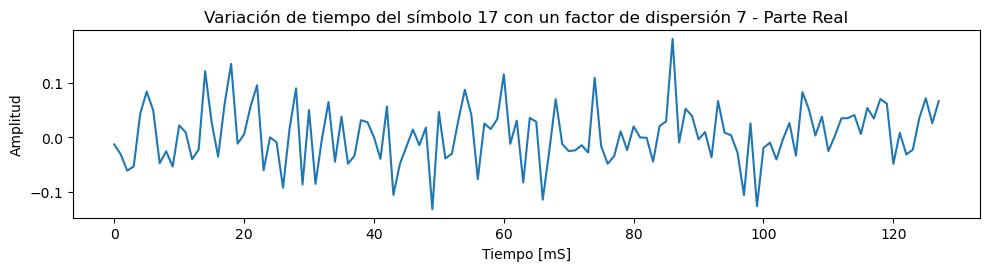

In [323]:
plt.figure(figsize=(10, 12))

# Subplot 3: Variación de tiempo por símbolo más ruido
plt.subplot(5, 1, 3)
plt.plot(time_axis, symb_ruidoso. real)

title_Text3 = f"Variación de tiempo del símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

#### Receptor

Debemos recordar que la señal a transmitir por la modulación LoRa tiene el siguiente formato:

<center> $|$ Preamble o Preámbulo $|$ Header o Encabezado (opcional) $|$ Payload o Información $|$ CRC (opcional) $|$ <center> 


Se va a suponer que el preámbulo y el encabezado (la parte de sincronización) ya ha sido solucionado, es decir, solo estamos transmitiendo y recibiendo los símbolos correspondientes.

En caso de recibir una señal con la estructura del paquete completa, se debe detectar las diferentes partes y eliminar las dos primeras para quedarnos con la información.


##### Demodulación

El receptor LoRa recibe una señal modulada que ha sido transmitida por un dispositivo emisor. Esta señal es una combinación de chirps ascendentes y descendentes que representan los datos modulados.

Para demodular la señal, el receptor necesita generar un _chirp_ de referencia descendente `base_down_chirp`. Este _chirp_ se utiliza para comparar y extraer la información de la señal recibida.

Entonces, se genera la señal de referencia descendente, `base_down_chirp`.

In [329]:
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)

k = 0

for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))  # Chirps descendentes

Y se puede gráficar para observar como sería la señal utilizada para la demodulación.

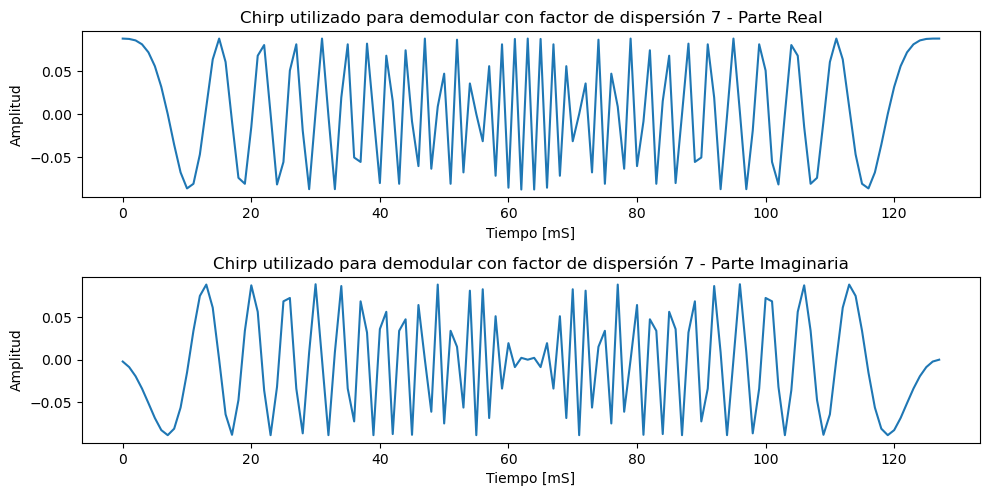

In [332]:
# Gráficas
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)
plt.plot(time_axis, base_down_chirp.real)
title_Text1 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.subplot(5, 1, 2)
plt.plot(time_axis, base_down_chirp.imag)
title_Text2 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Imaginaria"
plt.title(title_Text2)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

La señal recibida se multiplica por el _chirp_ descendente de referencia.

In [335]:
dechirped =  symb_ruidoso * base_down_chirp

Procedemos a graficar el símbolo demodulado.

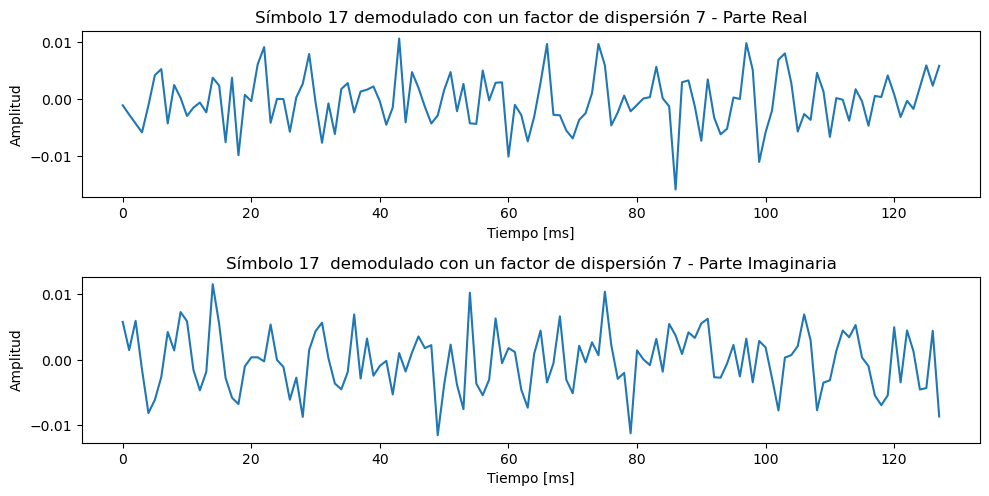

In [338]:
# Gráficas
plt.figure(figsize=(10, 12))

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 1)

plt.plot(time_axis, dechirped.real)
    
plt.title(f"Símbolo {str(s)} demodulado con un factor de dispersión {SF} - Parte Real")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 2)

plt.plot(time_axis, dechirped.imag)
    
plt.title(f"Símbolo {str(s)}  demodulado con un factor de dispersión {SF} - Parte Imaginaria")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Como podemos ver al demodular nos quedamos con un tono, es decir, una señal que tiene una frecuencia dominante.

Aplicando la Transformada Rápida de Fourier podemos saber cuales son los tonos de mayor potencia y de esta manera distinguir los símbolos enviados.

In [341]:
dechirped_fft = np.fft.fft(dechirped)

Nuevamente gráficamos, esta vez, la potencia de cada frecuencia para poder verificar a simple vista los primeros símbolos recibidos.

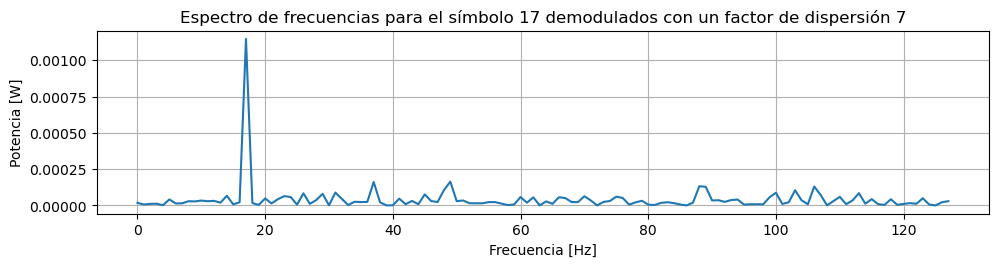

In [344]:
# Gráficas
plt.figure(figsize=(10, 12))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
power = np.abs(dechirped_fft)**2 / num_samples
plt.plot(f_sym, power)

plt.title(f"Espectro de frecuencias para el símbolo {str(s)} demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.grid()

plt.tight_layout()
plt.show()

Y como vemos coincide con el símbolo transmitido.

#### Calculo del error

Para calcular el error se realiza la modulación y demodulación varias veces. La cantidad de iteraciones se indico al comienzo con la variable `veces`.

Se generan y se demodulan los símbolos:

In [349]:
aciertos = np.zeros(veces, dtype=int)

for j in range(veces):
    symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)   # 1. Genero la modulación del símbolo
    
    symb_ruidoso = agregar_ruido(symb_t, SNR, ruido)        # 2. Agrego ruido 
    
    dechirped = symb_ruidoso * base_down_chirp              # 3. Demodulo
    
    dechirped_fft = np.fft.fft(dechirped)                   # 4. FFT  
    
    correlation = np.abs(dechirped_fft)**2                  # 5. Correlación
    
    aciertos[j] = correlation.argmax()                      # 6. Valor máximo en cada iteración

Se calcula la tasa de error:

In [352]:
symbol_error_rate = sum(aciertos != s)/veces

print("Tasa de error de símbolo:", symbol_error_rate)

Tasa de error de símbolo: 0.0


Se realiza el histograma de los símbolos demodulados.

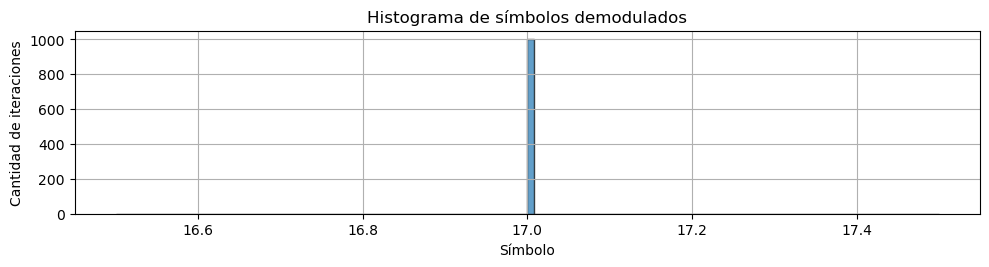

In [355]:
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)

plt.hist(aciertos, bins=2**SF, edgecolor='k', alpha=0.7)
plt.title("Histograma de símbolos demodulados")
plt.xlabel("Símbolo")
plt.ylabel("Cantidad de iteraciones")
plt.grid(True)

plt.tight_layout()
plt.show()

### Simulación de una transmisión y recepción con modulación LoRa de varios símbolos

La idea es la siguiente: 
> La cantidad de bits a transmitir va a depender del _Spreading Factor_, entonces primero se van a definir todos los parámetros que influyen en la simulación y en base a estos se va a generar el mensaje aleatorio a transmitir.
> 
> Este mensaje será modulado mediante LoRa, al cual se le puede agregar ruido gausiano, efectos del canal satelital o que sea un canal ideal.
>
> Cabe aclarar que no se van a generar los símbolos del preámbulo y de la sincronización, solo se va a modular y demodular la información. Los datos van a ser una serie de símbolos aleatorios, comprendidos entre $0$ y $2^{SF}$ de manera aleatoria.  
> 
> Luego se simula la recepción y se procede a analizar el error.

Se comienza definiendo los parámetros de la simulación:

* `SF` Puede tomar valores entre $7$ y $12$.

* `BW` es el ancho de banda en $Hz$. Me indica la diferencia entre la frecuencia inicial y final de los "chirridos".
  
* `SNR` es una medida que se utiliza para comparar el nivel de una señal deseada con el nivel de ruido de fondo. Se coloca en $dB$.
  
  Si es _positivo_ significa que la potencia de la señal es mayor que la potencia del ruido.

  Si es _negativo_ significa que la potencia del ruido es mayor que la potencia de la señal.
  
* `cant_bits` es la cantidad de símbolos a representar va a depender de `SF`.
  $$2^7 = 128$$
  $$2^8 = 256$$
  $$2^9 = 512$$
  $$2^{10} = 1024$$
  $$2^{11} = 2048$$
  $$2^{12} = 4096$$
* `Fs` es la frecuencia de muestreo, se utiliza para calcular el número de muestras en cada símbolo. 
* La variable `ruido` es para indicar el tipo del mismo. (0: sin ruido, 1: AWGN, 2: efectos del canal satelital) 

In [79]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
SNR = 0                  # Signal Noise Radio
cant_bits = 10000        # Cantidad de símbolos a transmitir  
Fs  = 1000               # Frecuencia de muestreo 
ruido = 1                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital                               

#### Transmisor

Teniendo en cuenta el factor de dispersión (`SF`), generamos el mensaje aleatorio a enviar. Serán símbolos aleatorios entre $0$ a $2^{SF} -1$.

In [82]:
x = np.random.randint(0, 2**SF, size=cant_bits)

El vector $x$ representa directamente la salida del encoder.

##### Modulación

Se procede a definir el periodo de cada símbolo y su tasa de muestreo para hacer uso de la función `generar_symb` definida anteriormente.

In [86]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Duración de casa símbolo:  0.128  [S]


Se definen las listas para guardar los resultado devueltos por la función. 
Y se recorre el vector que contiene la información ($x$), para modular cada símbolo:

In [88]:
all_symb_t = []
all_symb_f = []

# Recorrer el vector x y llamar a generar_symb para cada valor
for s in x:
    symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)
    all_symb_t.append(symb_t)
    all_symb_f.append(symb_f)

Procedemos a gráficar como se verían las variaciones de frecuencia y de tiempo por símbolo en el eje real.

Se puede mencionar que cambiando la variable `num_symbols_to_plot` se modifica la cantidad de símbolos a ver. Recordar que la cantidad total de símbolos se definió al principio con la variable `cant_bits` a transmitir.

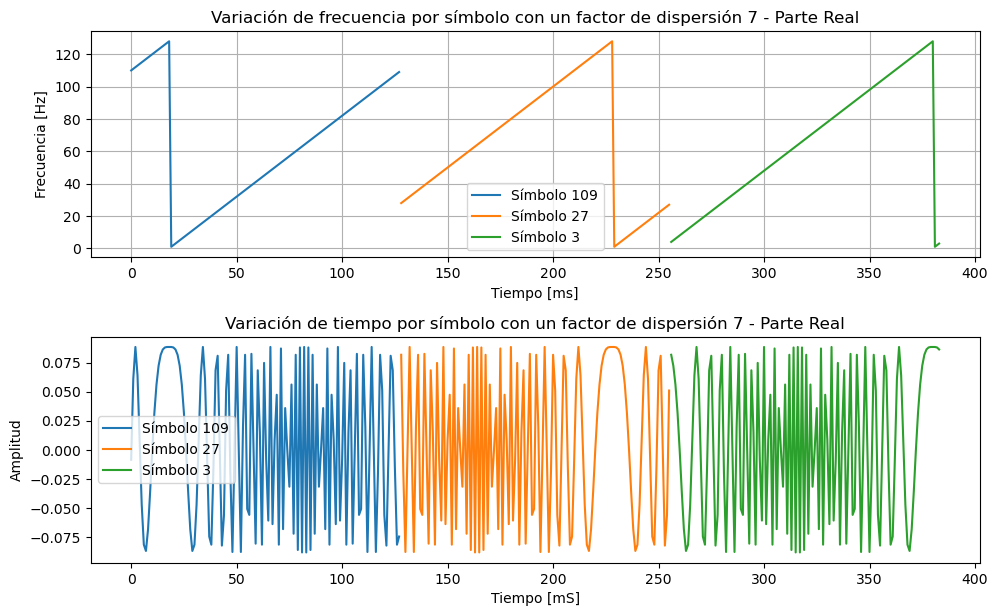

In [90]:
# Número de símbolos a graficar y parte del mensaje a mostrar
num_symbols_to_plot = 3
message_part = 2**SF   # Cantidad de puntos de cada símbolo

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 1: Variación de frecuencia por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_f[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text1 = f"Variación de frecuencia por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text1)
plt.xlabel("Tiempo [ms]")
plt.ylabel("Frecuencia [Hz]")
plt.legend()
plt.grid()

# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_t[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Con las imagenes anteriores podemos ver como es la modulación LoRa.

#### Ruido

En este momento se le puede agregar ruido a la señal, depende de como se configuro el parámetro antes. Para ello se utilizará la función `agregar_ruido` que se explicó antes.

Se generan los símbolos ruidosos.

In [94]:
symb_ruidosos = []

for symb in all_symb_t:
    symb_ruidoso = agregar_ruido(symb, SNR, ruido)
    symb_ruidosos.append(symb_ruidoso)

Y podemos nuevamente gráficar los primeros símbolos para apreciar el efecto.

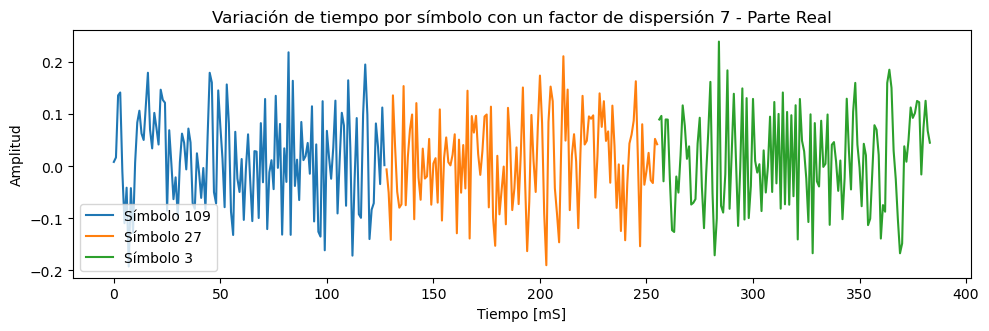

In [96]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 3)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, symb_ruidosos[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

#### Receptor

Para recibir la señal lo primero que se hace es detectar la parte del préambulo y de sincronización. Estas se eliminan, y nos quedamos con la información.

##### Demodulación

Para generar la demodulación, se debe generar un "chirp" o "chirrido" como antes vimos. De cierta manera es análogo a una señal portadora o _carrier_ en otras modulaciones como AM, FM, etc. 

In [101]:
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
k = 0

for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2))) # Chirps descendentes

Y se puede gráficar para observar como sería la señal utilizada para la demodulación.

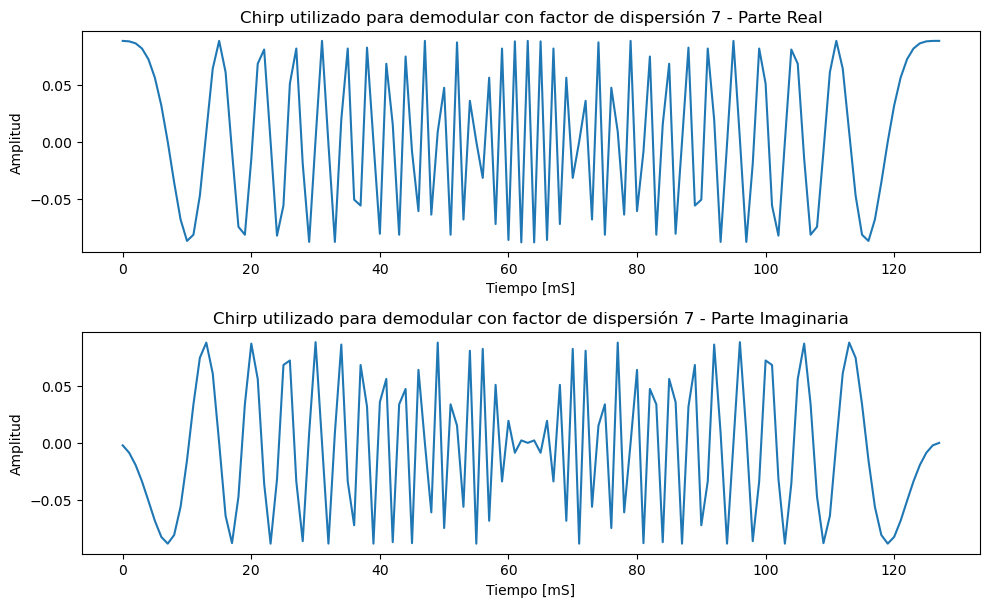

In [103]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en esta imagne y la siguiente

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 4)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].real)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Real"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.subplot(5, 1, 5)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].imag)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Imaginaria"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Notar que `time_axis` es un arreglo que contiene los tiempo correspondientes a cada "chirrido".
Se seleccionó la primer muestra del arreglo de tiempo con `message_part`, que me indica la cantidad de puntos de cada símbolo. De esta manera se definió el vector tiempo.

Y el vector `base_down_chirp` es el que contiene los valores del chirrido descendentes a lo largo del tiempo, como se indico un poco más arriba.

Ahora se realiza propiamente la demodulación, para ello se itera sobre cada símbolo y aplicó la demodulación a cada uno. Tener en cuenta que `symb_ruidosos` contiene los símbolos modulados con el ruido agregado.

In [105]:
all_dechirped = []

for i in symb_ruidosos:
    dechirped = i * base_down_chirp
    all_dechirped.append(dechirped)

Procedemos a graficar los símbolos demodulados.

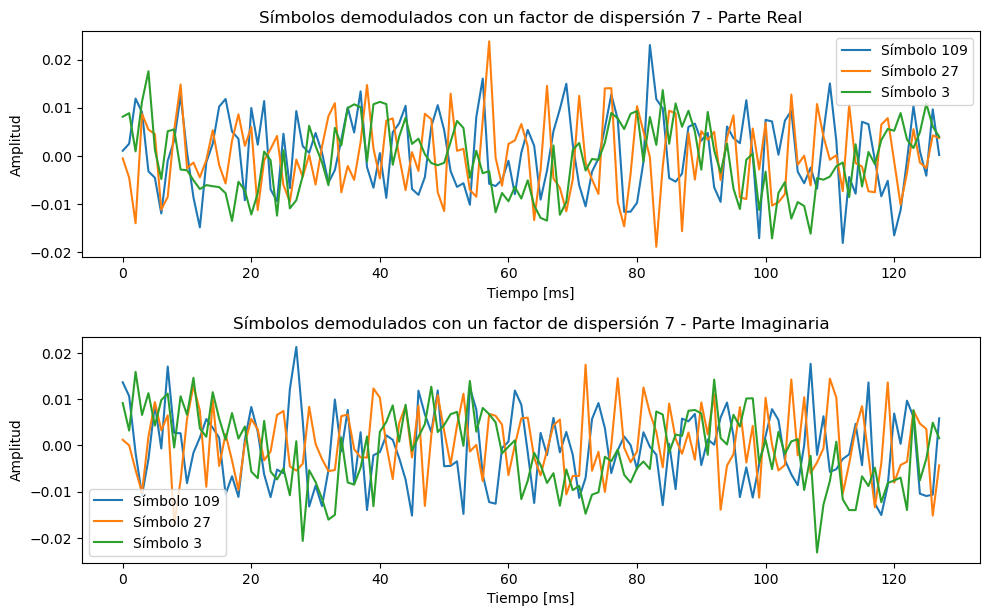

In [107]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].real, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Real")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].imag, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Imaginaria")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Como podemos ver al demodular nos quedamos con varios tonos, es decir, distintas señales de que tienen una frecuencia dominante.

Es necesario recordar que vamos a tener tantos tonos como símbolos diferentes tenga la señal.

Aplicando la Transformada Rápida de Fourier podemos saber cuales son los tonos de mayor potencia y de esta manera distinguir los símbolos enviados.

In [109]:
all_dechirped_fft = []

for i in all_dechirped:
    dechirped_fft = np.fft.fft(i)
    all_dechirped_fft.append(dechirped_fft)

Nuevamente gráficamos, esta vez, la amplitud de cada frecuencia para poder verificar a simple vista los primeros símbolos recibidos.

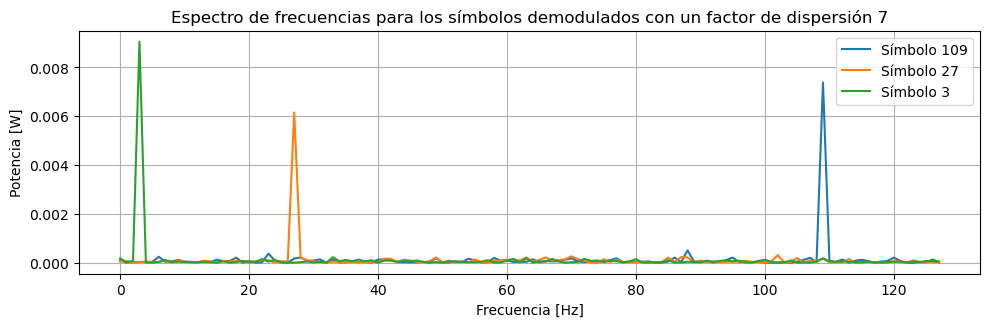

In [111]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
    power = np.abs(all_dechirped_fft[i])**2 / num_samples
    plt.plot(f_sym, power, label=f'Símbolo {x[i]}')

plt.title(f"Espectro de frecuencias para los símbolos demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Se puede ver que las frecuencias de mayor potencia representan a los símbolos obtenidos, que son iguales a los símbolos enviados.

Cambiando los parámetros del inicio de la simulación, obtenenmos diferentes casos, y poder ver como influye el ruido para distintos niveles de _Spreading Factor_. 

* `SF` Puede tomar valores entre $7$ a $12$
* `BW` es el ancho de banda en $Hz$
* `s` es el símbolo que se busca representar
* `SNR` es una medida que se utiliza para comparar el nivel de una señal deseada con el nivel de ruido de fondo. Se coloca en $dB$.
  
  Si es _positivo_ significa que la potencia de la señal es mayor que la potencia del ruido.

  Si es _negativo_ significa que la potencia del ruido es mayor que la potencia de la señal.
  
* `numero_ciclos`

In [114]:
SF  = 7     # Spreading Factor [7,8,9,10,11,12]
BW  = 1000  # Ancho de banda
s   = 17    # Símbolo a representar
SNR = 5     # Signal Noise Radio
numero_ciclos = 10000

generamos el símbolo con la siguiente operación:

$$\Large \frac{1}{\sqrt{2^{SF}}}e^{j2\pi\frac{k^2}{2^{SF}}}$$


In [116]:
var1 = 2**SF
num_samples = var1

k = s
simbolo_real = np.linspace(1, num_samples, num_samples)
simbolo_real = np.asarray(simbolo_real, dtype=int)
simbolo_lora = np.zeros(num_samples, dtype=complex)

i = 0

for i in range (0, num_samples):
    if(k >= var1):
        k = k - var1
    k = k + 1
    simb = (complex(1/(math.sqrt(var1)))*cmath.exp(1j*2*math.pi*k*(k/(2*var1))))
    simbolo_lora[i] = simb

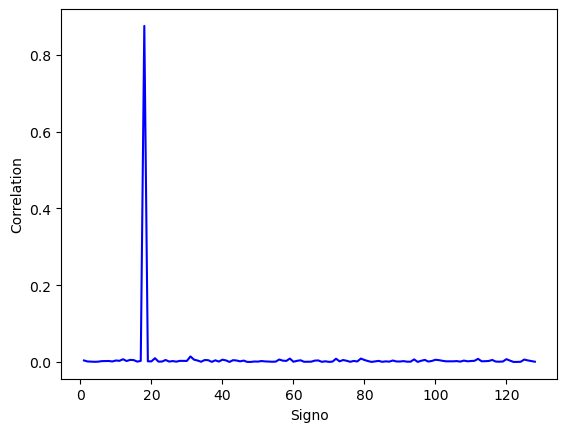

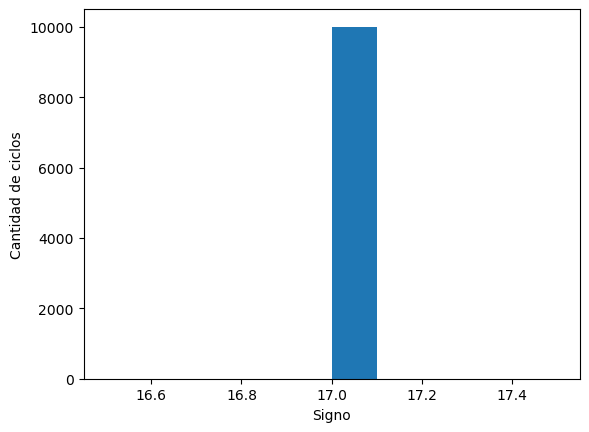

Error: 0.0


In [117]:
aciertos = np.zeros(numero_ciclos)
for i in range(0, numero_ciclos):
    
    #añadir ruido

    # Cálculo de potencia de señal y conversión a decibelios
    prom_watts = np.mean(np.abs(simbolo_lora)**2)
    prom_db = 10 * np.log10(prom_watts)

    # Cálculo de ruido en watts
    prom_ruido_db = prom_db - SNR
    noise_avg_watts = 10 ** (prom_ruido_db / 10)

    # Generar ruido blanco complejo
    noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(simbolo_lora)) + 1j * np.random.normal(0, 1, len(simbolo_lora)))

    # Añadir ruido a la señal original
    simb_ruidoso = simbolo_lora + noise

    # generando base down chirp
    base_down_chirp = np.zeros(num_samples, dtype=complex)
    k = 0
    for j in range (0, num_samples):
        if (k>=var1):
            k = k - var1
        k = k+1
        simb = (complex(1/math.sqrt(var1)))*cmath.exp(-1j*2*math.pi*k*(k/(2*var1)))
        base_down_chirp[j] = simb

    dechirped = simb_ruidoso*base_down_chirp #dechirping the signal

    #Fast Fourier Transform
    correlation = abs(fft(dechirped))**2

    #Encotrando el valor máximo
    aciertos[i] = correlation.argmax()

# plot the complex number
# La primera gráfica podemos ver la correlación, compara el símbolo enviado con cada símbolo desde 0 hasta 2^{SF}-1
plt.plot(simbolo_real, correlation, '-b')
plt.ylabel('Correlation')
plt.xlabel('Signo')
plt.show()

# La segunda gráfica me indica cuantas veces el programa dijo que era cierto símbolo.
plt.hist(aciertos)
plt.ylabel('Cantidad de ciclos')
plt.xlabel('Signo')
plt.show()

error = sum(aciertos != s)/numero_ciclos
print("Error: " + str(error))

Se puede concluir que para ambiente ruidosos, donde el ruido es mayor a la señal se debe utilizar un _Spreading Factor_ alto. 
Ej: SNR = -20 dB --> SF = 12 

En cambio para ambientes con poco ruido, con SF = 7 vemos que se obtiene un error también nulo. 

Simulación de la modulación LoRa y su comportamiento ante el ruido!

Se define la función para modular una onda para un símbolo dado *s*

In [121]:
def generar_symb(Ts, Fs, s, SF):
    
    num_samples = int(Ts * Fs)
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        if k >= 2**SF:
            k = k - 2**SF
        k = k + 1
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))

    return symb_t, symb_f

En la función anterior se esta modulando la señal para un símbolo *s* dado.

Se define la característica de la modulación, los parámetros son:

In [124]:
SF = 8
BW = 1000
Fs = 1000
s = 128 # Se define el símbolo que se va a transmitir
SNR = -10 # Se define la relación señal - ruido 

Se define el periodo de muestreo y la duración de cada símbolo

In [126]:
T = 1/BW           # Período de muestreo
Ts = 2**SF * T     # Período en general
num_sample = int(Ts*Fs) # Número de muestras

n_sy = 1 # Número de símbolos

Se calculan los símbolos para enviar un payload

In [128]:
[symb_t, symb_f] = generar_symb(Ts, Fs, s, SF)

Se define el vector tiempo para n_sy símbolos

In [130]:
x = np.linspace(0,n_sy*Ts, n_sy*(2**SF))

Se realiza la transmisión, para ello debemos generar un *chirp*. Es de ciertamente analogo a un carrier si lo comparamos con otras modulaciones.

In [132]:
base_down_chirp = np.zeros(num_sample, dtype=np.complex128)
k = 0

for n in range(num_sample):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

Ahora se realiza la demodulación:

In [134]:
dechirped = symb_t * base_down_chirp 
dechirped_fft = np.fft.fft(dechirped)

Generamos la transformada de Fourier:

In [136]:
n = len(dechirped_fft)  # número de muestras
f = np.arange(n) * (Fs / n)  # rango de frecuencia

f_sym = (f * 2**SF) / BW  # frecuencia simbólica

power = np.abs(dechirped_fft)**2 / n  # potencia de la señal

Los gráficos:

/home/mauricho/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mauricho/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


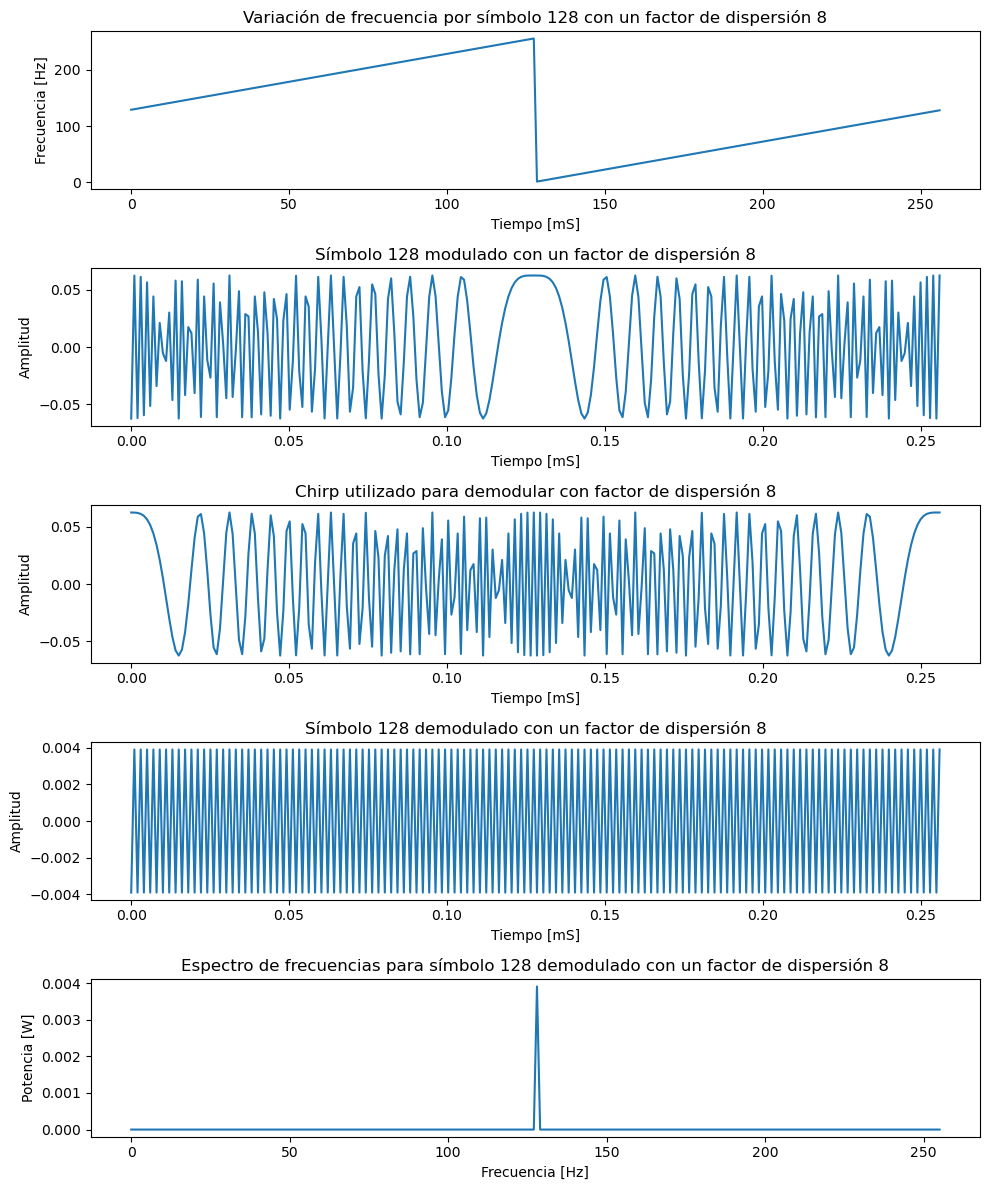

In [138]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación de frecuencia por símbolo
plt.subplot(5, 1, 1)
plt.plot(x * 1000, symb_f)
title_Text1 = "Variación de frecuencia por símbolo " + str(s) + " con un factor de dispersión " + str(SF)
plt.title(title_Text1)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Frecuencia [Hz]")

# Subplot 2: Símbolo modulado
plt.subplot(5, 1, 2)
plt.plot(x, symb_t)
title_Text2 = "Símbolo " + str(s) + " modulado con un factor de dispersión " + str(SF)
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 3)
plt.plot(x, base_down_chirp)
title_Text3 = "Chirp utilizado para demodular con factor de dispersión " + str(SF)
plt.title(title_Text3)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 4: Símbolo demodulado
plt.subplot(5, 1, 4)
plt.plot(x, dechirped)
title_Text4 = "Símbolo " + str(s) + " demodulado con un factor de dispersión " + str(SF)
plt.title(title_Text4)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 5: Espectro de frecuencias
plt.subplot(5, 1, 5)
plt.plot(f_sym, power)
title_Text5 = "Espectro de frecuencias para símbolo " + str(s) + " demodulado con un factor de dispersión " + str(SF)
plt.title(title_Text5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")

plt.tight_layout()  # Ajusta automáticamente el espaciado entre subplots
plt.show()

En la primer gráfica podemos ver que incia en la frecuencia del símbolo a transmitir y asciende hasta su máximo $2^{SF}$ provocando una discontinuidad, y vuelve a empezar.  

En la segunda gráfica se aprecia como cambia la frecuencia de la onda con la modulación _chirp_ para el símbolo a transmitir. Se nota que en la discontinuidad es donde se tiene menor frecuencia.

La tercer señal vemos el chirp utilizado para demodular. Es el conjugado de la modulación, es decir, el conjugado de la señal anterior.

En la cuarta gráfica se obtiene la señal demodulada, esta señal tiene una frecuencia constante y ese valor nos va a permitir saber el símbolo que se esta enviando.

Y en la última se muestran los valores de frecuencia de la señal anterior, y vemos claramente que la información se encuentra en la frecuencia. 


`Esta parte esta mal, no representa el error de la modulación LoRa.` _(PARTE DE ABAJO)_

Ahora se le agrega ruido a la simulación.

Se definen nuevamente las características de la modulación.

In [141]:
SF = 10
BW = 1000
Fs = 1000
s = 189
SNR = -20

Se define el número de muestras:

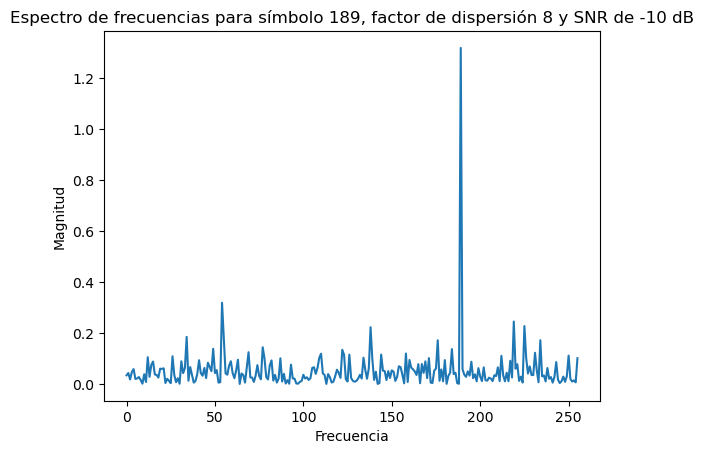

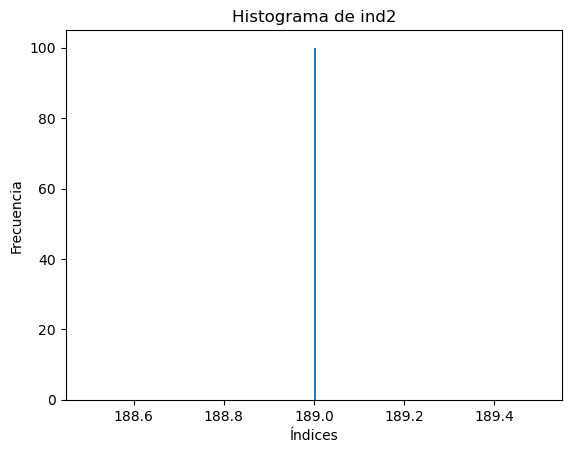

Tasa de error de símbolo: 1.0


In [143]:
# Configuración inicial
SF = 8
BW = 1000
Fs = 1000
s = 189
SNR = -10

# Número de muestras
num_samples = int((2**SF) * Fs / BW)
k = s
lora_symbol = np.zeros(num_samples, dtype=np.complex128)

# Se obtiene la señal modulada para el símbolo dado s
for n in range(num_samples):
    if k >= (2**SF):
        k = k - 2**SF
    k = k + 1
    lora_symbol[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2**SF * 2)))

ind2 = np.zeros(100, dtype=int)  # Arreglo para guardar los índices de máximos

for j in range(100):
    # Agrega ruido
    # Cálculo de potencia de señal y conversión a decibelios
    prom_watts = np.mean(np.abs(lora_symbol)**2)
    prom_db = 10 * np.log10(prom_watts)
    
    # Cálculo de ruido en watts
    prom_ruido_db = prom_db - SNR
    noise_avg_watts = 10 ** (prom_ruido_db / 10)
    
    # Generar ruido blanco complejo
    noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(lora_symbol)) + 1j * np.random.normal(0, 1, len(lora_symbol)))
    
    # Añadir ruido a la señal original
    lora_symbol_noisy = lora_symbol + noise

    # Transmite y se genera el chirp para demodular
    base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
    k = 0
    for n in range(num_samples):
        if k >= (2**SF):
            k = k - 2**SF
        k = k + 1
        base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

    # Demodulación
    dechirped = lora_symbol_noisy * base_down_chirp

    # Transformada rápida de Fourier - correlación
    corrs = np.abs(np.fft.fft(dechirped))**2

    # Encontrar el índice del máximo
    ind = np.argmax(corrs)
    ind2[j] = ind

# Figura 1
plt.figure(1)
plt.plot(corrs)
titleText = "Espectro de frecuencias para símbolo " + str(s) + ", factor de dispersión " + str(SF) + " y SNR de " + str(SNR) + " dB"
plt.title(titleText)
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")

# Figura 2
plt.figure(2)
plt.hist(ind2, bins=2**SF)
plt.title("Histograma de ind2")
plt.xlabel("Índices")
plt.ylabel("Frecuencia")
plt.show()

# Error de correlación
symbol_error_rate = np.sum(ind2 != s + 1) / len(ind2)
print("Tasa de error de símbolo:", symbol_error_rate)


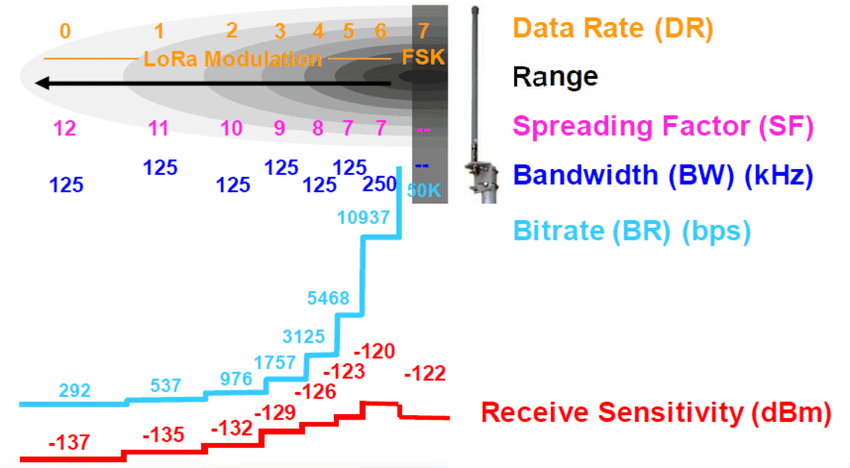

In [57]:
Image(filename='Imagenes/LoRa-Modulation-Parameters.png')

## Bibliografía

### Vídeos

* https://www.youtube.com/watch?v=8AWY80NKc-A
* https://www.youtube.com/watch?v=kNXnCjJplZw&t
* https://www.youtube.com/watch?v=mKmOlMqrbKk
* https://www.youtube.com/watch?v=dxYY097QNs0
* https://www.youtube.com/watch?v=0zNFtDZ7bMs
* https://www.youtube.com/watch?v=dpA-uWL6FUA
* https://www.youtube.com/watch?v=jHWepP1ZWTk
* https://www.youtube.com/watch?v=VipcNAGt89A
* https://www.youtube.com/watch?v=qs7Lz9g-mgg
* https://www.youtube.com/watch?v=YQ7aLHCTeeE

### Papers

* [L. Vangelista, "Frequency Shift Chirp Modulation: The LoRa Modulation", in IEEE Signal Processing Letters, vol. 24, no. 12, pp. 1818-1821, Dec. 2017, doi: 10.1109/LSP.2017.2762960](https://ieeexplore.ieee.org/document/8067462) 
* [Ullah, Pasolini, Mikhaylov, Alves, "Understanding the Limits of Lora Direct-to-Satellite: The Doppler Perspectives", in IEEE Open Journal of the Communications Society, vol. 5](https://ieeexplore.ieee.org/document/10335927/references#references)

### Páginas web

* https://www.sghoslya.com/p/lora_9.html
* http://www.sghoslya.com/
* https://revspace.nl/DecodingLora
* https://dl.acm.org/doi/10.1145/3546869#d1c2855
* https://cris.vtt.fi/en/publications/understanding-the-limits-of-lora-direct-to-satellite-the-doppler-
* https://en.wikipedia.org/wiki/Chirp
* https://wiki.dfrobot.com/What_is_LoRa
* https://www.digikey.es/es/articles/how-to-quickly-start-low-power-wireless-iot-sensing

### Repositorios

* https://github.com/rpp0/gr-lora